In [1]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Importing Libraries

In [0]:
import pandas as pd
import math
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection  import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

batch=100
data_count=2900

## Data Visualizations

In [3]:
COLUMNS = ['accX', 'accY', 'accZ','gyroX', 'gyroY', 'gyroZ']
sensor_data = []
PROJECT_DIR = "/content/drive/My Drive/Semester-2 Projects/ML Project/walking pattern/"
for i in range (1,4):
    file_path = PROJECT_DIR+'gyro/'+str(i)+'.csv'
    sensor_data.append((pd.read_csv(file_path,skiprows=1,header=None,names=COLUMNS))[:data_count])
sensor_data[0].head()

,accX,accY,accZ,gyroX,gyroY,gyroZ
0,0.408473,1.755781,-1.257742,0.497223,0.238037,-0.703217
1,0.408473,1.755781,-1.257742,0.497223,0.238037,-0.703217
2,0.408473,1.755781,-1.257742,0.497223,0.238037,-0.703217
3,0.408473,1.755781,-1.257742,0.497223,0.238037,-0.703217
4,0.408473,1.755781,-1.257742,0.497223,0.238037,-0.703217


In [4]:
sensor_data[0].count()

accX     2900
accY     2900
accZ     2900
gyroX    2900
gyroY    2900
gyroZ    2900
dtype: int64

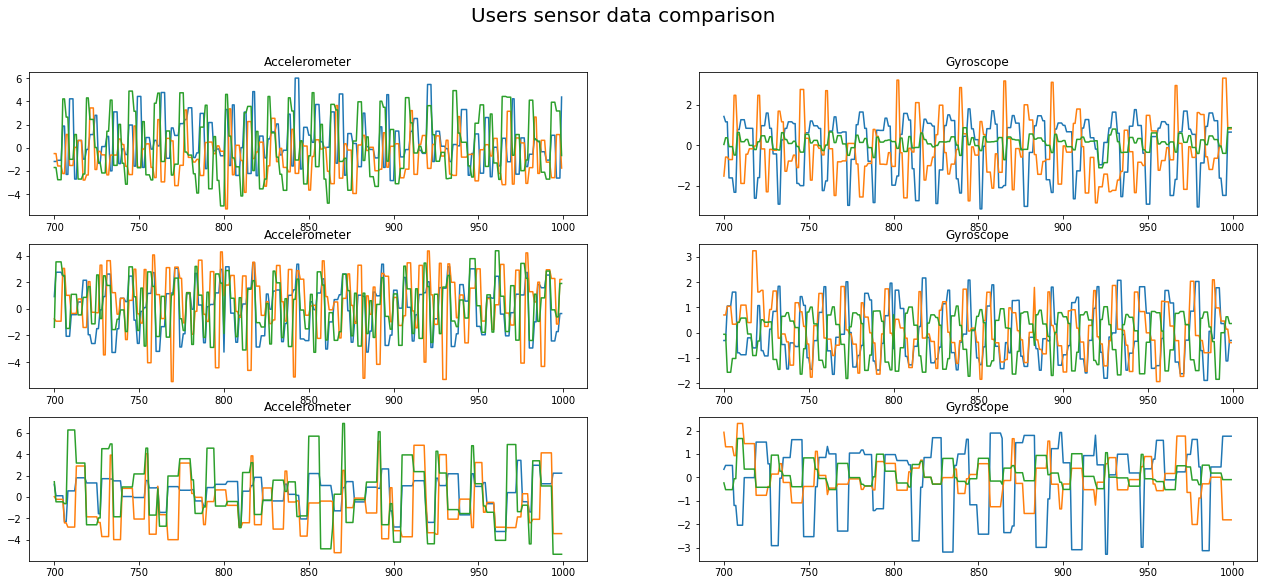

In [5]:
fig,ax=plt.subplots(figsize=(22, 9),nrows=3, ncols=2)

# fig.text(0.06, 0.5, 'User-1', ha='center', va='center', rotation='vertical')
fig.suptitle('Users sensor data comparison',fontsize=20)

for (row,i) in zip(ax,range(3)):
  for (col,j) in zip(row,range(2)):
    if j%2==0:
      col.plot(sensor_data[i].iloc[700:1000,:3])
      col.set_title('Accelerometer')
    else:
      col.plot(sensor_data[i].iloc[700:1000,3:])
      col.set_title('Gyroscope')

# Using Both Accelerometer and Gyroscope data

## Preprocessing Strategy
due to noise and
false readings the values of x, y and z axes cannot be
compared on one scale.
One very easy approach to solve this problem is to calculate
another axis called the Resultant vector from the magnitudes
of individual acceleration axes .

In [0]:
#Functions for calculating the Magnitude of any axis of Raw sensor Data
def magnitude(user_id):
    m2=0
    for col in COLUMNS:
      square = user_id[col]**2
      m2+=square
    m = m2.apply(lambda x: math.sqrt(x))
    return m
  
def total_acc(user_id):
    m2=0
    for col in COLUMNS[:3]:
      square = user_id[col]**2
      m2+=square
    m = m2.apply(lambda x: math.sqrt(x))
    return m
    
    
def calc_magnitudes():
    for i in range (3):
#         user_list[i]['magnitude'] = magnitude(user_list[i])
        user_list[i]['total_acc'] = total_acc(user_list[i])        
#     COLUMNS.append('magnitude')
    COLUMNS.append('total_acc')
        

#Function for defining the window on data
def window(axis,dx=batch):
    start = 0;
    size = axis.count();

    while (start < size):
        end = start + dx
        yield start,end
        start = start+int (dx/2)
        


#Features which are extracted from Raw sensor data
def window_summary(axis, start, end):
    acf = stattools.acf(axis[start:end])
    acv = stattools.acovf(axis[start:end])
    sqd_error = (axis[start:end] - axis[start:end].mean()) ** 2
    return [
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].var(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(axis[start:end]),
        kurtosis(axis[start:end]),
        math.sqrt(sqd_error.mean())
    ]

def features(user_id):
    for (start, end) in window(user_id[ COLUMNS[0] ]):
        features = []
        for axis in COLUMNS:
            features += window_summary(user_id[axis], start, end)
        yield features           
COLUMNS = ['accX', 'accY', 'accZ','gyroX', 'gyroY', 'gyroZ']

In [7]:
feature_names=['user_id']
# for c in COLUMNS+['magnitude','total_acc']:
for c in COLUMNS+['total_acc']:
  feature_names.append(c+'_mean')
  feature_names.append(c+'_std')
  feature_names.append(c+'_var')
  feature_names.append(c+'_min')
  feature_names.append(c+'_max')
  feature_names.append(c+'_acf_mean')
  feature_names.append(c+'_acf_std')
  feature_names.append(c+'_acv_mean')
  feature_names.append(c+'_acv_std')
  feature_names.append(c+'_skew')
  feature_names.append(c+'_kurtosis')
  feature_names.append(c+'_sqrt')
len(feature_names)

85

In [8]:
#Main code for Pre-processing of the Data
user_list = []
titles_list=[]
user_to_auth = 0
PROJECT_DIR = "/content/drive/My Drive/Semester-2 Projects/ML Project/walking pattern/"
for i in range (1,4):
    file_path = PROJECT_DIR+'gyro/'+str(i)+'.csv'
    user_list.append((pd.read_csv(file_path,skiprows=1,header=None,names=COLUMNS))[:data_count])
#     print("hye")
    
# print(user_list)
#Add an additional axis of magnitude of the sensor data
calc_magnitudes() 

#Write the feature vectors to a separate excel file
with open( PROJECT_DIR+'Features/Features-new6.csv', 'w') as out:
    rows = csv.writer(out)
    rows.writerow(feature_names)
    for i in range(0, len(user_list)):
        for f in features(user_list[i]):
            rows.writerow([i]+f)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


In [9]:
user_list[0].iloc[1]

accX         0.408473
accY         1.755781
accZ        -1.257742
gyroX        0.497223
gyroY        0.238037
gyroZ       -0.703217
total_acc    2.198075
Name: 1, dtype: float64

## Models Training using accelerometer and gyroscope

In [0]:
#Method for computing and plotting the confusion matrix, taken and modified from sklearn's official documentation website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2))+'%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Method for labelling the bar chart bars, taken from Matplotlib documentation
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % float(height),
                ha='center', va='bottom')

## Data Summary

In [11]:
pd.read_csv(PROJECT_DIR+'Features/Features-new6.csv',skiprows=0).describe()

,user_id,accX_mean,accX_std,accX_var,accX_min,accX_max,accX_acf_mean,accX_acf_std,accX_acv_mean,accX_acv_std,accX_skew,accX_kurtosis,accX_sqrt,accY_mean,accY_std,accY_var,accY_min,accY_max,accY_acf_mean,accY_acf_std,accY_acv_mean,accY_acv_std,accY_skew,accY_kurtosis,accY_sqrt,accZ_mean,accZ_std,accZ_var,accZ_min,accZ_max,accZ_acf_mean,accZ_acf_std,accZ_acv_mean,accZ_acv_std,accZ_skew,accZ_kurtosis,accZ_sqrt,gyroX_mean,gyroX_std,gyroX_var,...,gyroX_acv_std,gyroX_skew,gyroX_kurtosis,gyroX_sqrt,gyroY_mean,gyroY_std,gyroY_var,gyroY_min,gyroY_max,gyroY_acf_mean,gyroY_acf_std,gyroY_acv_mean,gyroY_acv_std,gyroY_skew,gyroY_kurtosis,gyroY_sqrt,gyroZ_mean,gyroZ_std,gyroZ_var,gyroZ_min,gyroZ_max,gyroZ_acf_mean,gyroZ_acf_std,gyroZ_acv_mean,gyroZ_acv_std,gyroZ_skew,gyroZ_kurtosis,gyroZ_sqrt,total_acc_mean,total_acc_std,total_acc_var,total_acc_min,total_acc_max,total_acc_acf_mean,total_acc_acf_std,total_acc_acv_mean,total_acc_acv_std,total_acc_skew,total_acc_kurtosis,total_acc_sqrt
count,174.000000,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,170.000000,170.000000,174.000000,174.000000,174.000000,174.000000,1.740000e+02,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,174.000000,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,1.740000e+02,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,174.000000,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,1.740000e+02,174.000000,1.740000e+02,1.740000e+02,...,1.740000e+02,174.000000,174.000000,1.740000e+02,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,170.000000,170.000000,174.000000,174.000000,174.000000,174.000000,1.740000e+02,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,174.000000,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,1.740000e+02,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,174.000000,174.000000,1.740000e+02,1.740000e+02,174.000000,174.000000,1.740000e+02
mean,1.000000,0.328147,1.446790e+00,2.385664e+00,-2.508259,3.332752,0.047481,0.266519,0.011921,0.436549,-0.037673,0.755017,1.439457e+00,-0.190824,1.843957e+00,3.882479e+00,-3.983696,3.446301,0.065920,0.243557,1.948386e-02,6.660483e-01,-0.047594,0.690468,1.834591e+00,0.302524,2.232022e+00,5.756551e+00,-3.608142,4.610764,0.061783,0.256522,2.867574e-02,1.084500e+00,0.193934,0.371723,2.220729e+00,-0.033216,1.313743e+00,1.924930e+00,...,4.709212e-01,-0.167784,0.218381,1.307069e+00,-0.012861,9.605703e-01,1.034084e+00,-2.006964,2.036537,0.047753,0.299316,0.005170,0.217510,0.113602,0.392488,9.556908e-01,0.065879,5.451051e-01,3.687746e-01,-0.974719,1.189352,0.052712,0.294645,1.848459e-03,8.022132e-02,0.068614,0.479961,5.423361e-01,3.237584,1.525874e+00,2.606733e+00,0.763130,6.429023,0.079314,0.287188,1.300765e-02,5.695087e-01,0.240515,0.233326,1.518136e+00
std,0.818853,0.701633,5.423591e-01,1.363639e+00,1.482056,1.520275,0.093798,0.062237,0.006857,0.254097,1.100595,4.876446,5.396431e-01,0.900257,6.964832e-01,2.304894e+00,1.848157,1.327089,0.149880,0.059303,1.219210e-02,4.485459e-01,1.078800,4.550538,6.929235e-01,0.720771,8.826703e-01,3.539908e+00,1.844417,1.823466,0.148325,0.053207,1.759206e-02,7.232939e-01,0.962722,4.980427,8.782976e-01,0.222899,4.473935e-01,9.483301e-01,...,2.648982e-01,1.173272,6.488301,4.451871e-01,0.453908,3.347131e-01,6.284915e-01,1.383607,0.933750,0.094999,0.051743,0.003128,0.122228,0.892705,3.021635,3.330618e-01,0.195569,2.684196e-01,3.172005e-01,0.700212,0.949675,0.144925,0.069342,1.608628e-03,7.305400e-02,1.065173,3.430382,2.670595e-01,0.945216,5.291976e-01,1.563457e+00,0.870996,1.883032,0.154681,0.059669,7.732616e-03,3.909951e-01,1.040189,4.489066,5.266005e-01
min,0.000000,-0.874550,7.810713e-16,6.100724e-31,-10.830166,0.000000,-0.072649,0.118322,0.000000,0.000000,-6.857143,-3.000000,7.771561e-16,-2.154470,4.463264e-16,1.992073e-31,-8.071599,0.000000,-0.047548,0.118322,1.556151e-33,8.895045e-34,-5.510378,-2.000000,4.440892e-16,-2.339330,4.463264e-16,1.992073e-31,-9.313847,0.000000,-0.021678,0.118322,1.556151e-33,

## Classifying Features
Testing Different Classifiers i.e. Baseline Classifier,Random Forest Classifier
               KNN,Decision Tree,Linear SVM,RBF SVM

In [0]:
dataset = np.loadtxt(PROJECT_DIR+'Features/Features-new6.csv', delimiter=",",skiprows=1)

X = dataset[:, 1:]                      
X=np.nan_to_num(X)
y = dataset[:, 0]      
class_names = ['user-1','user-2','user-3']

classifiers = {'Baseline Classifier':DummyClassifier(),'Random Forest Classifier':RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
               'KNN':KNeighborsClassifier(10),'Decision Tree':DecisionTreeClassifier(max_depth=6),'Linear SVM':SVC(kernel="linear", C=0.025),'RBF SVM':SVC(gamma=2, C=1)}
classifiers_title = list(classifiers.keys())               
scores=np.empty(10)
means_scores=[]
stddev_scores=[]

#dividing the dataset into training and testing (training 70% and test=30%)
X_train,X_test,y_train,y_test = train_test_split (X,y,test_size=0.3)

In [13]:
print('Train set: X=',X_train.shape,'y=',y_train.shape)
print('Test set: X=',X_test.shape,'y=',y_test.shape)

Train set: X= (121, 84) y= (121,)
Test set: X= (53, 84) y= (53,)


In [14]:
print(np.all(np.isfinite(X)),np.any(np.isnan(X)))

True False


Baseline Classifier 0.4716981132075472
[Results For  Baseline Classifier ] Mean:  0.33999999999999997  Std Dev:  0.10137328647072927
Random Forest Classifier 0.9056603773584906
[Results For  Random Forest Classifier ] Mean:  0.8844444444444444  Std Dev:  0.09258962958222071
KNN 0.8490566037735849
[Results For  KNN ] Mean:  0.8466666666666667  Std Dev:  0.09092121131323903
Decision Tree 0.9056603773584906
[Results For  Decision Tree ] Mean:  0.8255555555555556  Std Dev:  0.16307613915129898
Linear SVM 0.9245283018867925
[Results For  Linear SVM ] Mean:  0.8633333333333333  Std Dev:  0.10196222975345476
RBF SVM 0.3018867924528302
[Results For  RBF SVM ] Mean:  0.34444444444444444  Std Dev:  0.022222222222222233


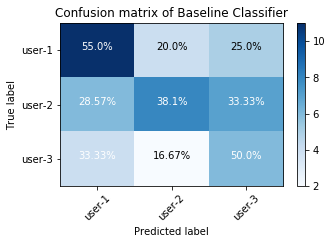

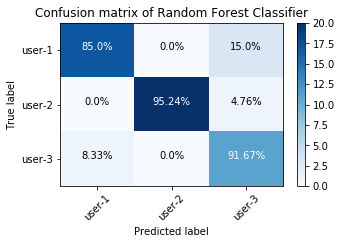

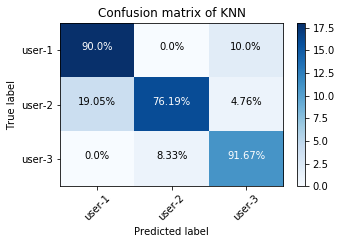

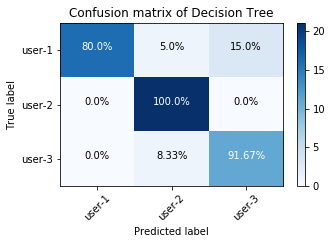

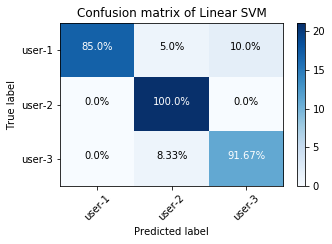

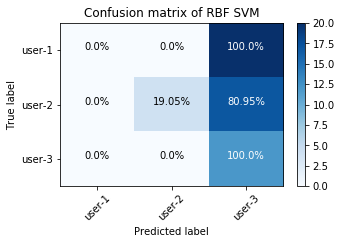

In [15]:
#Performing classification using each classifier and computing the 10-Fold cross-validation on results
for i in range(classifiers.__len__()):
    classifiers[classifiers_title[i]].fit (X_train,y_train)
    y_pred = classifiers[classifiers_title[i]].predict(X_test)
    
    print(classifiers_title[i],accuracy_score(y_test,y_pred))
    
    scores = cross_val_score(classifiers[classifiers_title[i]],X,y,cv=10)
    # Plot normalized confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5,3))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title=('Confusion matrix of ' + classifiers_title[i]))
    
    mean = scores.mean()
    stdev = scores.std()
    means_scores.append(mean)
    stddev_scores.append(stdev)
    print("[Results For ",classifiers_title[i], "] Mean: ",mean," Std Dev: ",stdev)

In [16]:
np.arange(6)

array([0, 1, 2, 3, 4, 5])

([<matplotlib.axis.XTick at 0x7f589dea9f98>,
 <a list of 3 Text xticklabel objects>)

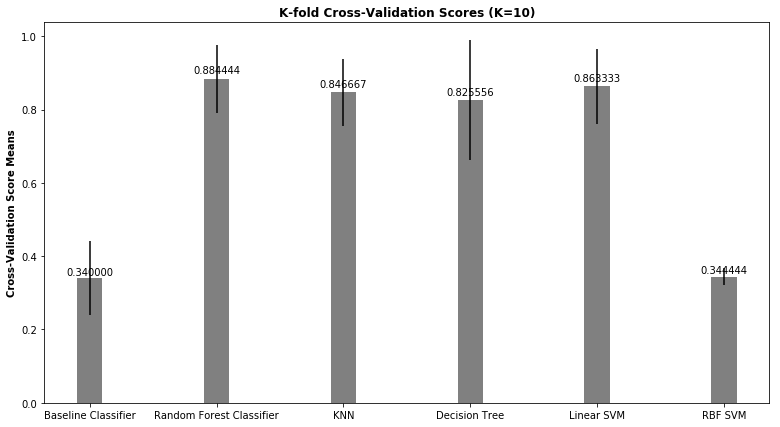

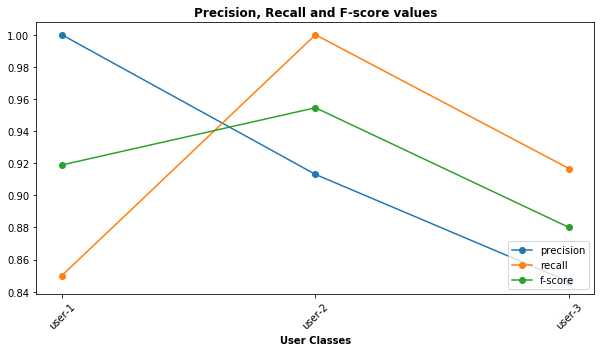

In [17]:
#plotting the bar chart showing each classifier's mean and std deviation of cross-validation score
fig,ax= plt.subplots(figsize=(13,7))
rect1 = ax.bar(np.arange(6),means_scores,0.2,color='gray',yerr=stddev_scores)
ax.set_title('K-fold Cross-Validation Scores (K=10)',weight='bold')
ax.set(xticks=range(0, 6),xticklabels=classifiers_title)
ax.set_ylabel('Cross-Validation Score Means',weight='bold')
autolabel(rect1)


#calculating the precision, recall, fscore and support for the best classifier i.e. Linear SVM
y_pred = classifiers['Linear SVM'].predict(X_test)
prec_rec_fscore_supt = precision_recall_fscore_support(y_test,y_pred)

#plotting precision,recall and fscore values for each class of users
fig,ax = plt.subplots(figsize=(10, 5))
x= np.arange(1,4)
ax.plot(x,prec_rec_fscore_supt[0],'o-')
ax.plot(x,prec_rec_fscore_supt[1],'o-')
ax.plot(x,prec_rec_fscore_supt[2],'o-')

ax.legend(['precision','recall','f-score'],loc='lower right')
ax.set_xlabel ('User Classes',weight='bold')
ax.set_title ('Precision, Recall and F-score values',weight='bold')

plt.xticks(x, class_names, rotation=45)

### Neural Network

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras import metrics
from keras import backend as K
import keras
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

Using TensorFlow backend.


In [19]:
model = Sequential([
    Dense(units=256,input_shape = (7*12,),activation='relu'),
    Dropout(0.6),
    Dense(units=128,activation='relu'),
    Dense(units=3,activation='softmax',)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               21760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 55,043
Trainable params: 55,043
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x=X_train,y=y_train,batch_size=25,epochs=50,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 3s - loss: 1.6059 - acc: 0.4132
Epoch 2/50
 - 0s - loss: 1.0816 - acc: 0.5041
Epoch 3/50
 - 0s - loss: 1.0066 - acc: 0.5537
Epoch 4/50
 - 0s - loss: 0.8107 - acc: 0.5868
Epoch 5/50
 - 0s - loss: 0.6527 - acc: 0.7521
Epoch 6/50
 - 0s - loss: 0.5515 - acc: 0.7603
Epoch 7/50
 - 0s - loss: 0.5479 - acc: 0.7438
Epoch 8/50
 - 0s - loss: 0.3652 - acc: 0.9008
Epoch 9/50
 - 0s - loss: 0.4187 - acc: 0.8347
Epoch 10/50
 - 0s - loss: 0.2838 - acc: 0.9008
Epoch 11/50
 - 0s - loss: 0.3991 - acc: 0.8843
Epoch 12/50
 - 0s - loss: 0.2731 - acc: 0.9091
Epoch 13/50
 - 0s - loss: 0.2971 - acc: 0.9008
Epoch 14/50
 - 0s - loss: 0.2198 - acc: 0.9256
Epoch 15/50
 - 0s - loss: 0.1883 - acc: 0.9504
Epoch 16/50
 - 0s - loss: 0.1996 - acc: 0.9339
Epoch 17/50
 - 0s - loss: 0.2347 - acc: 0.9174
Epoch 18/50
 - 0s - loss: 0.2226 - acc: 0.9008
Epoch 19/50
 - 0s - loss: 0.1824 - acc: 0.9256
Epoch 20/50
 - 0s - loss: 0.1653 - acc: 0.9339
Epoch 21/50
 - 0s - l

In [22]:
#Model Evaluation
model.evaluate(X_test,y_test)

53/53 [==============================] - 0s 737us/step


[0.13400278943327237, 0.9811320754716981]

# Training using only accelerometer data

In [0]:
#Functions for calculating the Magnitude of any axis of Raw sensor Data
def magnitude(user_id):
    m2=0
    for col in COLUMNS:
      square = user_id[col]**2
      m2+=square
    m = m2.apply(lambda x: math.sqrt(x))
    return m
    
    
def calc_magnitudes():
    for i in range (1,4):
        user_list[i-1]['total_acc'] = magnitude(user_list[i-1])
    COLUMNS.append('total_acc')       

In [24]:
COLUMNS = ['accX', 'accY', 'accZ']
# ['accX', 'accY', 'accZ','gyroX', 'gyroY', 'gyroZ']
feature_names=['user_id']
for c in COLUMNS+['total_acc']:
  feature_names.append(c+'_mean')
  feature_names.append(c+'_std')
  feature_names.append(c+'_var')
  feature_names.append(c+'_min')
  feature_names.append(c+'_max')
  feature_names.append(c+'_acf_mean')
  feature_names.append(c+'_acf_std')
  feature_names.append(c+'_acv_mean')
  feature_names.append(c+'_acv_std')
  feature_names.append(c+'_skew')
  feature_names.append(c+'_kurtosis')
  feature_names.append(c+'_sqrt')
len(feature_names)

49

In [25]:
#Main code for Pre-processing of the Data

user_list = []
titles_list=[]
user_to_auth = 0
PROJECT_DIR = "/content/drive/My Drive/Semester-2 Projects/ML Project/walking pattern/"
for i in range (1,4):
    file_path = PROJECT_DIR+'gyro/'+str(i)+'.csv'
    user_list.append((pd.read_csv(file_path,skiprows=1,header=None,names=COLUMNS))[:data_count])

#Add an additional axis of magnitude of the sensor data
calc_magnitudes() 

#Write the feature vectors to a separate excel file
with open( PROJECT_DIR+'Features/Features-new3.csv', 'w') as out:
    rows = csv.writer(out)
    rows.writerow(feature_names)
    for i in range(0, len(user_list)):
        for f in features(user_list[i]):
            rows.writerow([i]+f)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


In [26]:
#magnitude is resultant vector
user_list[0].iloc[1]

accX         0.497223
accY         0.238037
accZ        -0.703217
total_acc    0.893536
Name: (0.408473, 1.7557811999999997, -1.2577421999999998), dtype: float64

## Classifying Features
Testing Different Classifiers i.e. Baseline Classifier,Random Forest Classifier
               KNN,Decision Tree,Linear SVM,RBF SVM

In [27]:
df=pd.read_csv(PROJECT_DIR+'Features/Features-new3.csv',skiprows=1)

df=df.dropna()
dataset=df.as_matrix()
# dataset = np.loadtxt(PROJECT_DIR+'Features/Features-new.csv', delimiter=",",skiprows=1)
print(type(dataset))

#Note on Numpy array splicing
#our_array[a:b,c:d]  a and b = rows index of array && c and d = column index of array 


X = dataset[:, 1:]                      #array of 61x84 dimensons i.e. 61 feature vectors each having 84 dimensions
y = dataset[:, 0]      
class_names = ['user-1','user-2','user-3']

#dividing the dataset into training and testing (training 70% and test=30%)
X_train,X_test,y_train,y_test = train_test_split (X,y,test_size=0.3)

<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Baseline Classifier 0.19607843137254902
[Results For  Baseline Classifier ] Mean:  0.3549101307189543  Std Dev:  0.10454896813714008
Random Forest Classifier 0.8823529411764706
[Results For  Random Forest Classifier ] Mean:  0.8767401960784313  Std Dev:  0.07076829312619731
KNN 0.8235294117647058
[Results For  KNN ] Mean:  0.876470588235294  Std Dev:  0.11145812784963112
Decision Tree 0.8431372549019608
[Results For  Decision Tree ] Mean:  0.8748937908496732  Std Dev:  0.10240853256689608
Linear SVM 0.7843137254901961
[Results For  Linear SVM ] Mean:  0.8517483660130718  Std Dev:  0.1194505477102757
RBF SVM 0.6470588235294118
[Results For  RBF SVM ] Mean:  0.6687990196078432  Std Dev:  0.061015076603415576


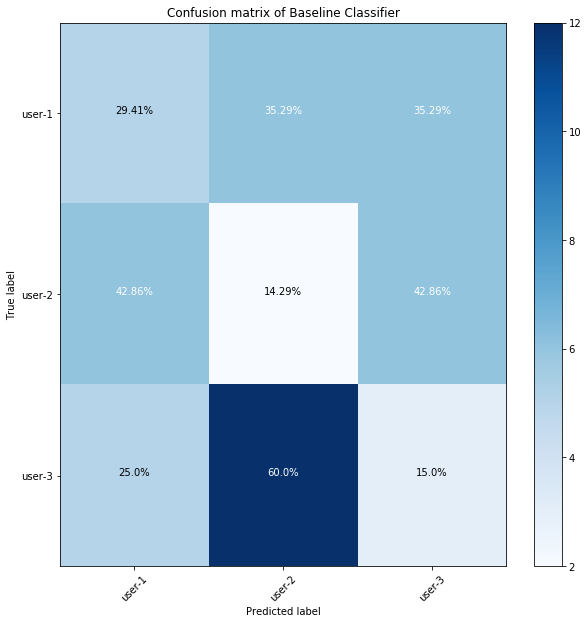

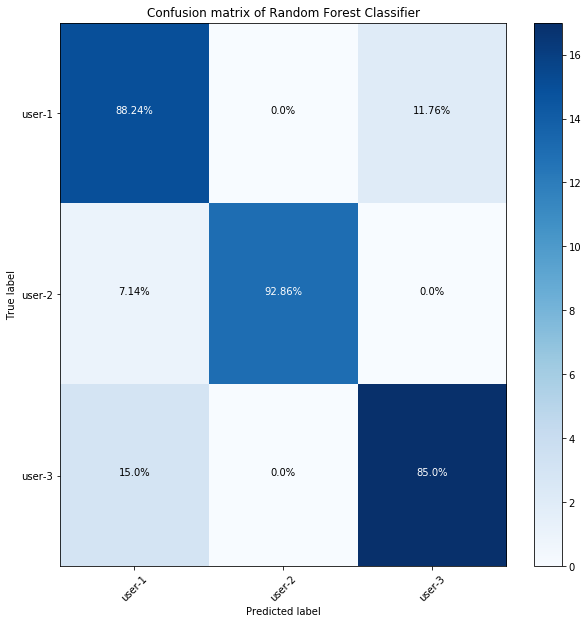

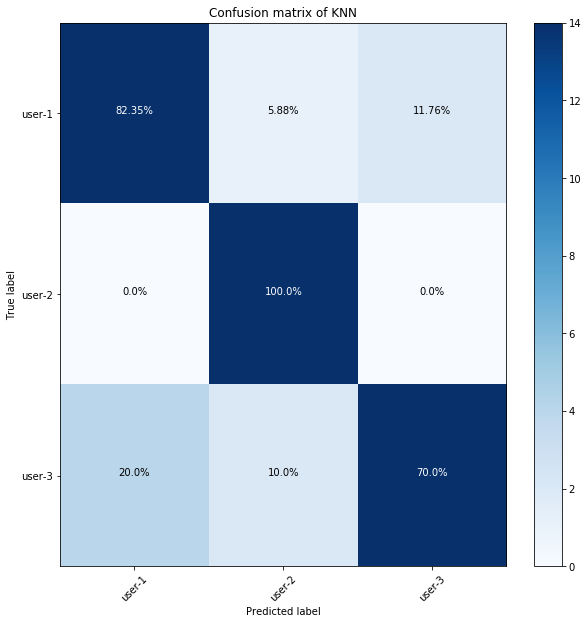

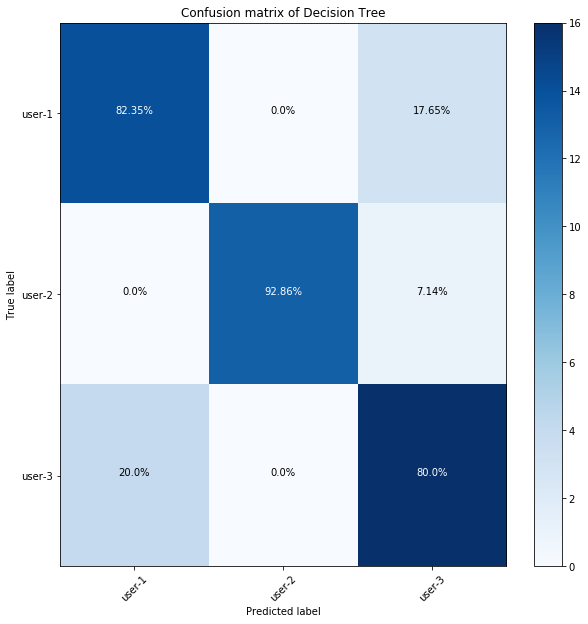

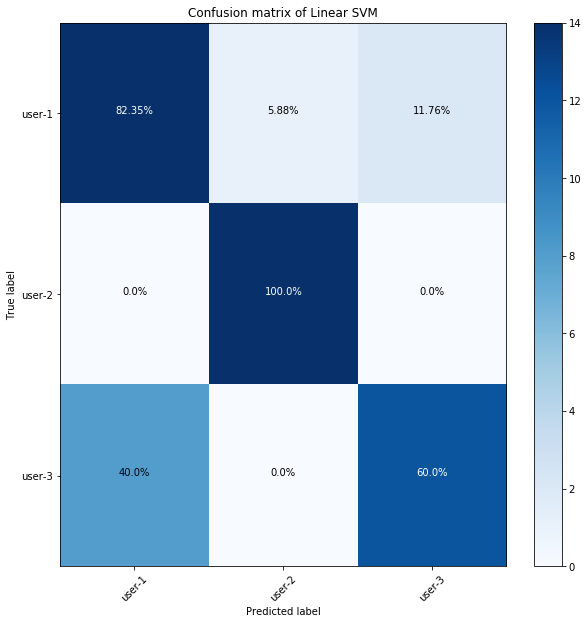

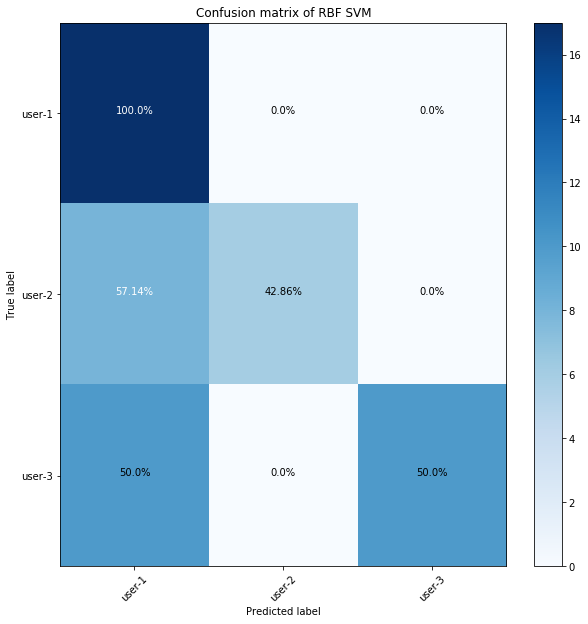

In [28]:

classifiers = {'Baseline Classifier':DummyClassifier(),'Random Forest Classifier':RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
               'KNN':KNeighborsClassifier(10),'Decision Tree':DecisionTreeClassifier(max_depth=6),'Linear SVM':SVC(kernel="linear", C=0.025),'RBF SVM':SVC(gamma=2, C=1)}
classifiers_title = list(classifiers.keys())               
scores=np.empty(10)
means_scores=[]
stddev_scores=[]


#Performing classification using each classifier and computing the 10-Fold cross-validation on results
for i in range(classifiers.__len__()):
    classifiers[classifiers_title[i]].fit (X_train,y_train)
    y_pred = classifiers[classifiers_title[i]].predict(X_test)
    
    print(classifiers_title[i],accuracy_score(y_test,y_pred))
    
    scores = cross_val_score(classifiers[classifiers_title[i]],X,y,cv=10)
    # Plot normalized confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title=('Confusion matrix of ' + classifiers_title[i]))
    
    mean = scores.mean()
    stdev = scores.std()
    means_scores.append(mean)
    stddev_scores.append(stdev)
    print("[Results For ",classifiers_title[i], "] Mean: ",mean," Std Dev: ",stdev)
 

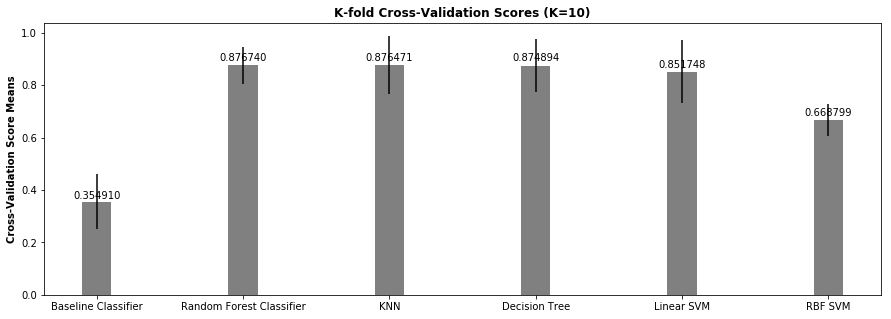

In [29]:
 #plotting the bar chart showing each classifier's mean and std deviation of cross-validation score
fig,ax= plt.subplots(figsize=(15, 5))


rect1 = ax.bar(np.arange(6),means_scores,0.2,color='gray',yerr=stddev_scores)
ax.set_title('K-fold Cross-Validation Scores (K=10)',weight='bold')
inds = np.linspace(0,len(classifiers_title)-1,3).astype(int)
ax.set(xticks=range(0, 6),xticklabels=classifiers_title)
ax.set_ylabel('Cross-Validation Score Means',weight='bold')
autolabel(rect1)



([<matplotlib.axis.XTick at 0x7f583c67fef0>,
 <a list of 3 Text xticklabel objects>)

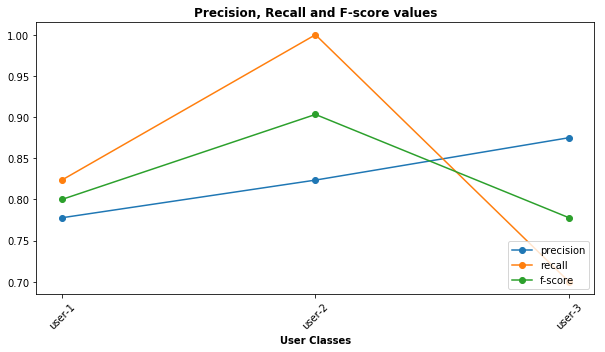

In [30]:
#calculating the precision, recall, fscore and support for the  classifier i.e. KNN
y_pred = classifiers['KNN'].predict(X_test)
prec_rec_fscore_supt = precision_recall_fscore_support(y_test,y_pred)

#plotting precision,recall and fscore values for each class of users
fig,ax = plt.subplots(figsize=(10, 5))
x= np.arange(1,4)
ax.plot(x,prec_rec_fscore_supt[0],'o-')
ax.plot(x,prec_rec_fscore_supt[1],'o-')
ax.plot(x,prec_rec_fscore_supt[2],'o-')

ax.legend(['precision','recall','f-score'],loc='lower right')
ax.set_xlabel ('User Classes',weight='bold')
ax.set_title ('Precision, Recall and F-score values',weight='bold')

plt.xticks(x, class_names, rotation=45)